In [58]:
from scipy.sparse import csr_matrix

import seml
import pandas as pd
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2
%load_ext lab_black

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [59]:
results = seml.get_results("moscot_map", to_data_frame=True)

  0%|          | 0/701 [00:00<?, ?it/s]

  0%|          | 0/701 [00:00<?, ?it/s]

In [60]:
results["corrvalue"] = [pd.Series(["pearson", "spearman"]) for i in range(len(results))]
results["size"] = results["result.adata_sp_size"] + results["result.adata_sc_size"]
cols = [
    "config.method",
    "result.time",
    "size",
    "config.params.epsilon",
    "config.params.alpha",
    "config.dataset",
]
cols_explode = [
    "result.corr_results_mean",
    "result.corr_results_var",
    "result.corr_results_median",
    "corrvalue",
]
corr_df = results[cols + cols_explode].explode(cols_explode)
corr_df.columns = [
    "method",
    "time",
    "n_cells",
    "epsilon",
    "alpha",
    "dataset",
    "mean_corr",
    "var_corr",
    "median_corr",
    "corrvalue",
]

In [61]:
corr_df

,method,time,n_cells,epsilon,alpha,dataset,mean_corr,var_corr,median_corr,corrvalue
0,MOSCOT,36.507849,2177,0.10,0.5,45,0.018771,0.003491,0.011396,pearson
0,MOSCOT,36.507849,2177,0.10,0.5,45,0.023094,0.003639,0.019472,spearman
1,MOSCOT,34.615102,2177,0.10,0.9,45,0.010385,0.00162,0.006446,pearson
1,MOSCOT,34.615102,2177,0.10,0.9,45,0.011044,0.00144,0.008416,spearman
2,MOSCOT,34.136273,2177,0.01,0.5,45,0.004819,0.002018,-0.005069,pearson
...,...,...,...,...,...,...,...,...,...,...
698,GIMVI,25.369374,1549,NaN,NaN,10,-0.010056,0.00197,-0.004026,spearman
699,GIMVI,26.170984,1549,NaN,NaN,10,-0.011512,0.00351,-0.006673,pearson
699,GIMVI,26.170984,1549,NaN,NaN,10,-0.0042,0.003473,-0.008515,spearman
700,GIMVI,24.147453,1549,NaN,NaN,10,0.023076,0.001014,0.026011,pearson


In [62]:
corr_df.n_cells.unique().shape

(31,)

In [63]:
corr_df[corr_df.method.isin(["MOSCOT"])].groupby(["epsilon", "alpha"])[
    ["mean_corr", "median_corr"]
].mean()

mean_corr  median_corr
epsilon alpha                        
0.005   0.5     0.166779     0.145728
        0.9     0.087006     0.071800
0.010   0.5     0.178874     0.159329
        0.9     0.090510     0.077834
0.100   0.5     0.229252     0.211531
        0.9     0.078427     0.068586

In [85]:
corr_df["method"] = corr_df["method"].replace(
    {"MOSCOT": "moscot", "GIMVI": "gimVI", "TANGRAM": "Tangram"}
)

In [86]:
gimvi = corr_df[corr_df.method == "gimvi"].reset_index()
tangram = corr_df[corr_df.method == "tangram"].reset_index()
cond = (corr_df.epsilon == 0.01) & (corr_df.alpha == 0.5) & (corr_df.method == "moscot")
moscot = corr_df[cond].reset_index()

In [87]:
moscot

,index,method,time,n_cells,epsilon,alpha,dataset,mean_corr,var_corr,median_corr,corrvalue
0,2,moscot,34.136273,2177,0.01,0.5,45,0.004819,0.002018,-0.005069,pearson
1,2,moscot,34.136273,2177,0.01,0.5,45,0.016906,0.002026,0.012165,spearman
2,8,moscot,17.918579,2177,0.01,0.5,45,0.009416,0.004331,-0.00463,pearson
3,8,moscot,17.918579,2177,0.01,0.5,45,0.017106,0.004747,0.01182,spearman
4,14,moscot,32.731984,2177,0.01,0.5,45,0.004713,0.002925,-0.005144,pearson
...,...,...,...,...,...,...,...,...,...,...,...
175,546,moscot,40.294745,1549,0.01,0.5,10,0.082788,0.00282,0.077488,spearman
176,552,moscot,17.548378,1549,0.01,0.5,10,0.096666,0.003681,0.087773,pearson
177,552,moscot,17.548378,1549,0.01,0.5,10,0.148403,0.005497,0.137997,spearman
178,558,moscot,15.915617,1549,0.01,0.5,10,0.071215,0.004669,0.061251,pearson


In [88]:
final_df = pd.concat([gimvi, tangram, moscot]).reset_index()
# final_df = final_df.groupby(["method", "dataset"]).mean(["mean_corr"]).reset_index()
# final_df

In [89]:
final_df["ones"] = 1
final_df = final_df[final_df.corrvalue == "spearman"].copy()

In [90]:
all_datasets = (
    final_df[["method", "dataset", "ones"]].groupby(["dataset"]).count().reset_index()
)
datasets = all_datasets[all_datasets.method == 9].dataset.unique()

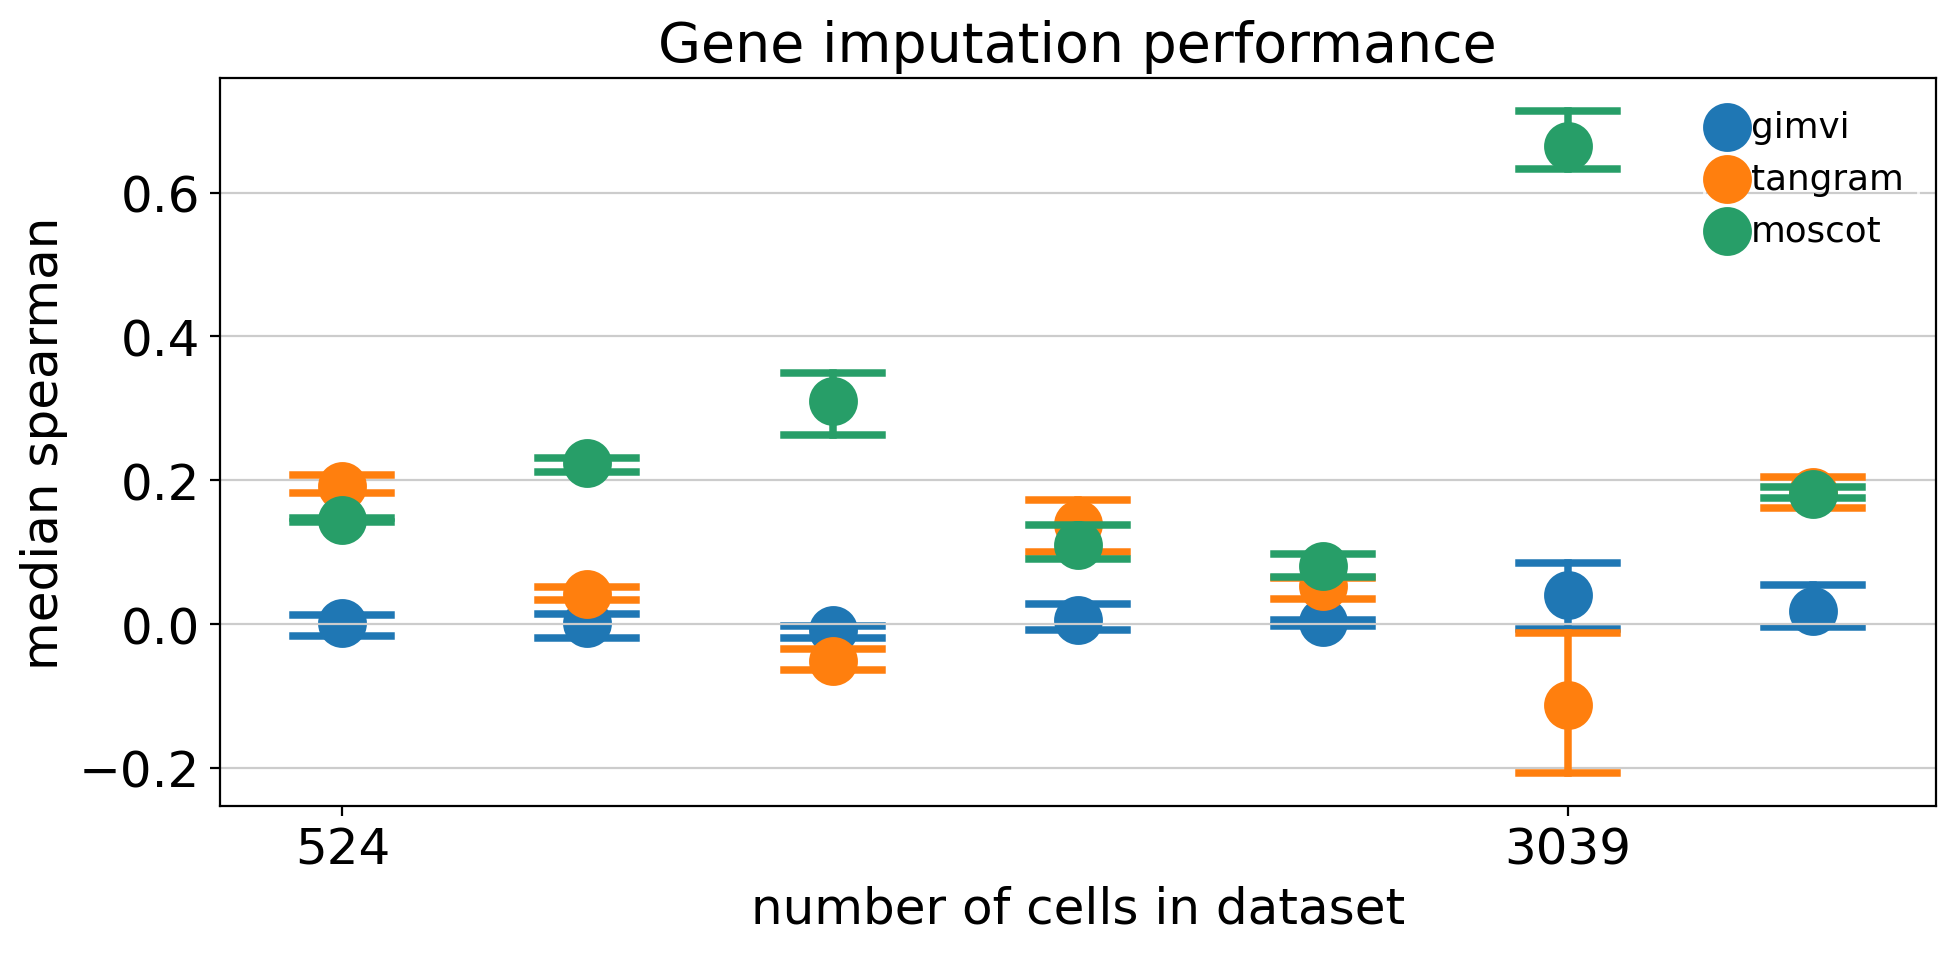

In [92]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
# g = sns.boxplot(
#     data=final_df[final_df.corrvalue == "spearman"],
#     x="n_cells",
#     y="median",
#     hue="method",
#     dodge=True,
#     ax=ax,
# )

sns.pointplot(
    data=final_df[final_df.dataset.isin(datasets)],
    x="n_cells",
    y="median_corr",
    hue="method",
    dodge=False,
    jitter=1.5,
    # s=50,
    scale=2,
    linestyles="",
    edgecolors="black",
    capsize=0.4,
    linewidth=1,
    ax=ax,
)
legend = plt.legend()

legend.get_frame().set_facecolor("none")
legend.get_frame().set_edgecolor("white")
ticks, labels = plt.xticks()
plt.xticks(ticks[::5], labels[::5])

ax.set_ylabel("median spearman", fontsize=18)

ax.set_xlabel("number of cells in dataset", fontsize=18)
ax.tick_params(axis="both", which="major", labelsize=18)
ax.set_title("Gene imputation performance", fontsize=20)
plt.tight_layout()

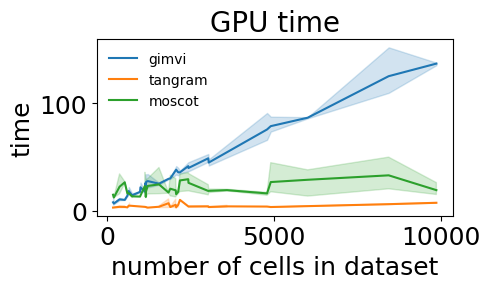

In [13]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(5, 3), dpi=100)
# g = sns.boxplot(
#     data=final_df[final_df.corrvalue == "spearman"],
#     x="n_cells",
#     y="median",
#     hue="method",
#     dodge=True,
#     ax=ax,
# )

sns.lineplot(
    data=final_df[final_df.corrvalue == "spearman"],
    x="n_cells",
    y="time",
    hue="method",
    ax=ax,
)
legend = plt.legend()

legend.get_frame().set_facecolor("none")
legend.get_frame().set_edgecolor("white")
# ticks, labels = plt.xticks()
# plt.xticks(ticks[::5], labels[::5])

ax.set_ylabel("time", fontsize=18)

ax.set_xlabel("number of cells in dataset", fontsize=18)
ax.tick_params(axis="both", which="major", labelsize=18)
ax.set_title("GPU time", fontsize=20)
plt.tight_layout()

In [14]:
moscot[moscot.median_corr.values > 0.5]

,index,method,time,n_cells,epsilon,alpha,dataset,mean_corr,var_corr,median_corr,corrvalue
98,304,moscot,16.915856,3039,0.01,0.5,14,0.78276,0.00741,0.778286,pearson
99,304,moscot,16.915856,3039,0.01,0.5,14,0.633859,0.014169,0.645503,spearman
100,310,moscot,20.225586,3039,0.01,0.5,14,0.813524,0.011051,0.867887,pearson
101,310,moscot,20.225586,3039,0.01,0.5,14,0.621111,0.032656,0.633432,spearman
102,316,moscot,18.503091,3039,0.01,0.5,14,0.832172,0.005576,0.868569,pearson
103,316,moscot,18.503091,3039,0.01,0.5,14,0.622053,0.04844,0.713752,spearman


In [15]:
from pathlib import Path
import scanpy as sc
import anndata as ad
import squidpy as sq
import numpy as np

path_read = Path("/lustre/groups/ml01/workspace/giovanni.palla/moscot/processed_data")
path_data = "/lustre/groups/ml01/workspace/giovanni.palla/moscot/processed_data"
dataset = 14
seed = 42
adata_sp = ad.read(Path(path_data) / f"dataset{dataset}_sp.h5ad")
rng = np.random.default_rng(seed)
if "highly_variable" in adata_sp.var.columns:
    adata_sp = adata_sp[:, adata_sp.var.highly_variable].copy()
    n_genes = 100
else:
    n_genes = 10

adata_sp_a = sc.pp.subsample(adata_sp, fraction=0.5, copy=True, random_state=seed)
adata_sp_b = adata_sp[~np.in1d(adata_sp.obs_names, adata_sp_a.obs_names)].copy()

# test_var = rng.choice(adata_sp.var_names, n_genes, replace=False).tolist()
# train_var = adata_sp_a.var_names[~np.in1d(adata_sp_a.var_names, test_var)].tolist()
# true_df = sc.get.obs_df(adata_sp_b, keys=test_var)

# adata_sp_a_train = adata_sp_a[:, train_var].copy()
# adata_sp_b_train = adata_sp_b[:, train_var].copy()

# sc.tl.pca(adata_sp_b_train)
# sc.tl.pca(adata_sp_a_train)
# adata_sp_a.obsm["X_pca"] = adata_sp_a_train.obsm["X_pca"].copy()

In [16]:
adata_sp.obsm["spatial_2D_"] = adata_sp.obsm["spatial"][:, [0, 2]]

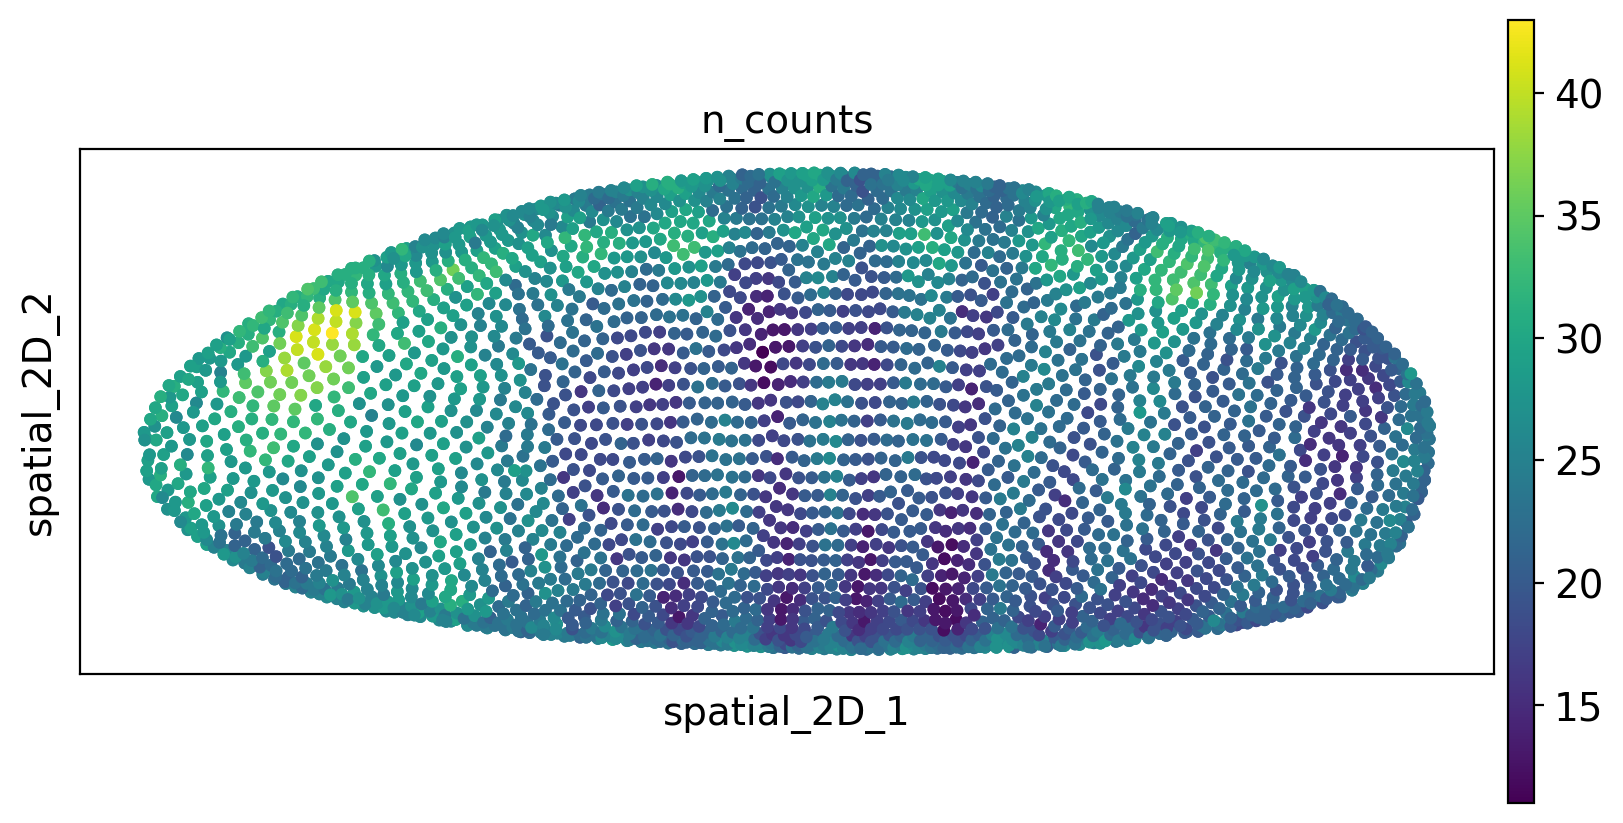

In [17]:
sc.set_figure_params(figsize=(8, 4), dpi=100)
sq.pl.spatial_scatter(
    adata_sp, color="n_counts", spatial_key="spatial_2D_", shape=None, size=50
)

In [18]:
adata_sp.obsm["spatial_2D_"] = adata_sp.obsm["spatial"][:, [1, 2]]

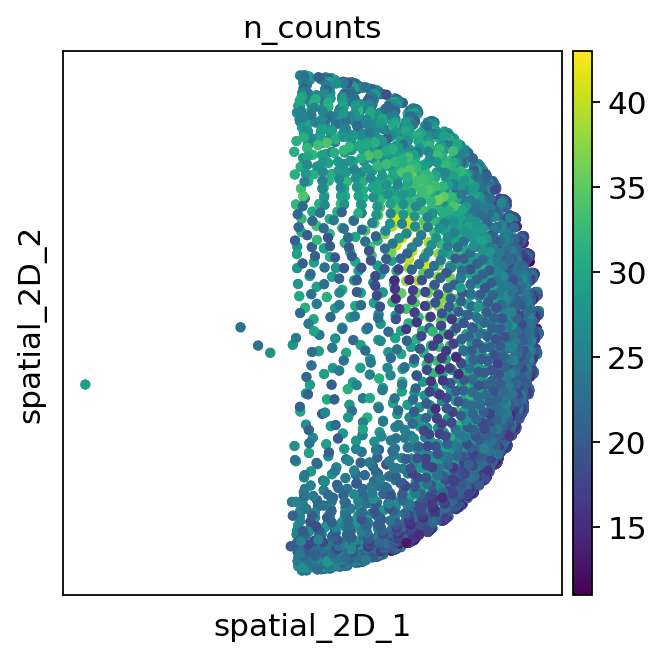

In [19]:
sc.set_figure_params(figsize=(8, 4))
sq.pl.spatial_scatter(
    adata_sp, color="n_counts", spatial_key="spatial_2D_", shape=None, size=50
)

In [62]:
moscot[moscot.n_cells.values > 5000].dataset.unique()

array([ 1, 39, 41])

In [63]:
from pathlib import Path
import scanpy as sc
import anndata as ad
import squidpy as sq
import numpy as np

path_read = Path("/lustre/groups/ml01/workspace/giovanni.palla/moscot/processed_data")
path_data = "/lustre/groups/ml01/workspace/giovanni.palla/moscot/processed_data"
dataset = 41
seed = 42
adata_sp = ad.read(Path(path_data) / f"dataset{dataset}_sp.h5ad")
rng = np.random.default_rng(seed)
if "highly_variable" in adata_sp.var.columns:
    adata_sp = adata_sp[:, adata_sp.var.highly_variable].copy()
    n_genes = 100
else:
    n_genes = 10

adata_sp_a = sc.pp.subsample(adata_sp, fraction=0.5, copy=True, random_state=seed)
adata_sp_b = adata_sp[~np.in1d(adata_sp.obs_names, adata_sp_a.obs_names)].copy()
# test_var = rng.choice(adata_sp.var_names, n_genes, replace=False).tolist()
# train_var = adata_sp_a.var_names[~np.in1d(adata_sp_a.var_names, test_var)].tolist()
# true_df = sc.get.obs_df(adata_sp_b, keys=test_var)

# adata_sp_a_train = adata_sp_a[:, train_var].copy()
# adata_sp_b_train = adata_sp_b[:, train_var].copy()

# sc.tl.pca(adata_sp_b_train)
# sc.tl.pca(adata_sp_a_train)
# adata_sp_a.obsm["X_pca"] = adata_sp_a_train.obsm["X_pca"].copy()

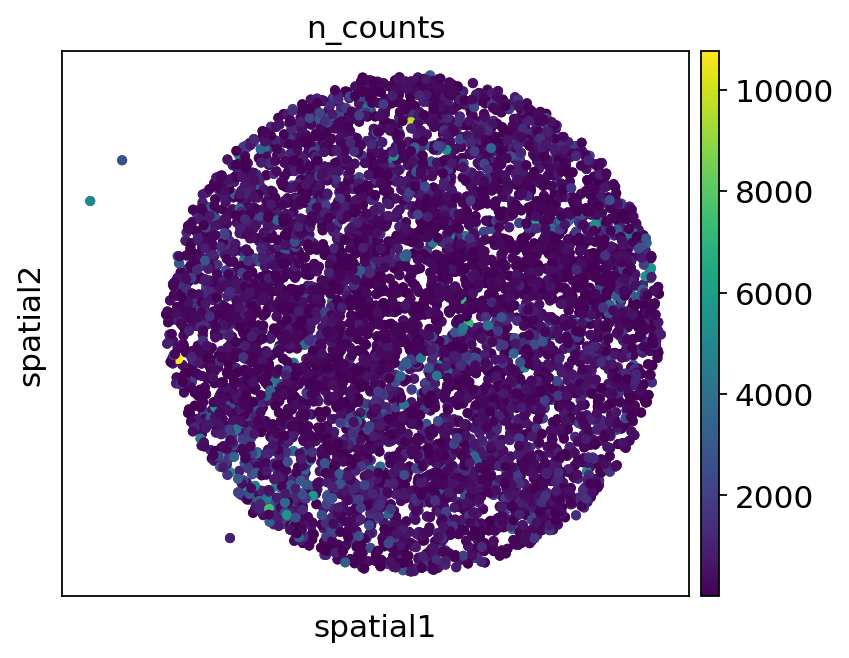

In [64]:
sc.set_figure_params(figsize=(8, 4))
sq.pl.spatial_scatter(
    adata_sp, color="n_counts", spatial_key="spatial", shape=None, size=50
)